In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json

In [130]:
sns.set_theme()
sns.set_style("ticks")
sns.set_context("paper")
sns.set_theme(style="white") #, font_scale=0.5)
# plt.style.use(['seaborn-paper', 'seaborn-ticks'])
sns.set_color_codes()

In [131]:
import imageio
import rasterio
from rasterio import features
from rasterio import plot
from rasterio import windows
from rasterio import transform

In [132]:
import geopandas

In [133]:
data_pth_ngi = '/media/tvanzyl/data/ngi/2529CD/{filename}'
data_pth_csv = '/media/tvanzyl/data/neof/{filename}'

In [134]:
src_mask = rasterio.open(data_pth_csv.format(filename='avgSpatialCoh.tiff'))
src = rasterio.open(data_pth_ngi.format(filename="2529CD_09_2018_1318_RGB_RECT.tif"))

Ingest ground truth from 2018

In [136]:
gdf_18 = geopandas.read_file(data_pth_csv.format(filename='coalhaul_visuals_2018.csv'), )
gdf_18[gdf_18==''] = None
gdf_18 = gdf_18.set_geometry( geopandas.GeoSeries.from_wkt(gdf_18.geom).set_crs("EPSG:4326") )
gdf_18.assessment_date = pd.to_datetime(gdf_18.assessment_date)
gdf_18.drop_duplicates(['road_nr', 'link_nr', 'from_km'], inplace=True, ignore_index=True)
gdf_18.set_index(['road_nr', 'link_nr', 'from_km',], inplace=True)

In [137]:
gdf_18.shape

(917, 98)

In [138]:
gdf_18.assessment_date.min(), gdf_18.assessment_date.max()

(Timestamp('2018-04-10 00:00:00'), Timestamp('2018-06-24 00:00:00'))

Select relevant subset of fields from ground truth

In [139]:
cols = ['geometry', 
 'risfsa_class', 'moisture_zone', 'terrain', 'functional_class', 'road_type', 'road_type_coto', 
 'road_width_m', 
 'width_m', 'lanes', 
 'surface_failures_d', 'surface_failures_e', 
 'surface_cracks_d', 'surface_cracks_e', 
 'stone_loss_d', 'stone_loss_e', 
 'dry_brittle_d', 'dry_brittle_e', 
 'bleeding_d', 'bleeding_e', 
 'block_cracks_d', 'block_cracks_e', 'longitudinal_cracks_d', 'longitudinal_cracks_e', 'transverse_cracks_d', 'transverse_cracks_e', 'crocodile_creacks_d', 'crocodile_cracks_e', 
 'pumping_d', 'pumping_e', 
 'rutting_d', 'rutting_e', 
 'undulation_settlement_d', 'undulation_settlement_e', 
 'patching_d', 'patching_e', 
 'failures_potholes_d', 'failures_potholes_e', 
 'edge_breaks_d', 'edge_breaks_e', 
 'riding_quality',  
 'vci']
# 'assessment_date''route''stone_loss_an','shoulders_unpaved','surface_drainage',

gdf_18 = gdf_18[cols]

Remove empty rows and cols

In [140]:
gdf_18.dropna(axis='columns', how='all', inplace=True)
gdf_18.dropna(axis='index', how='any', inplace=True)
gdf_18.shape

(896, 40)

Subset rows from 2018

In [141]:
index = gdf_18.index
geometry = gdf_18.loc[index].geometry

Subset the numeric columns only

In [142]:
numeric_cols = [
       'surface_failures_d', 'surface_failures_e',
       'failures_potholes_d', 'failures_potholes_e', 
       # 'surface_cracks_d', 'surface_cracks_e', 
       'stone_loss_d', 'stone_loss_e',
       # 'dry_brittle_d', 'dry_brittle_e', 
       'bleeding_d', 'bleeding_e',
       'block_cracks_d', 'block_cracks_e', 'longitudinal_cracks_d', 'longitudinal_cracks_e', 
       'transverse_cracks_d', 'transverse_cracks_e', 'crocodile_creacks_d', 'crocodile_cracks_e', 
       'pumping_d', 'pumping_e', 'rutting_d', 'rutting_e', 
       'undulation_settlement_d', 'undulation_settlement_e', 
       'edge_breaks_d', 'edge_breaks_e', 
       'patching_d', 'patching_e', 
       'road_width_m','width_m', 'lanes', 'riding_quality', 'vci']

In [143]:
gdf_18 = gdf_18[numeric_cols].astype(float)

Select the correct target data

In [144]:
gdf = gdf_18.loc[index, numeric_cols]
gdf = gdf.set_geometry(geometry.to_crs(src.crs))

In [145]:
gdf = gdf.reset_index(drop=True)

In [146]:
res = features.rasterize( ((row.geometry, idx) for idx, row in gdf.iterrows()), fill=-1, transform=src.transform, out_shape=src.shape, all_touched=False)
mask = (res>=0) #& (src_mask.read(1)>0)

In [147]:
mask.any()

np.True_

In [148]:
rstsource = src.files[0].split("/")[-1].split(".")[0]
rstpath = data_pth_csv.format(filename=f'{rstsource}')

In [149]:
!mkdir {rstpath}

In [150]:
i = 0
seq = []
idxs = []
for idx, row in gdf.iterrows():
    bound = row.geometry.bounds
    rst = src.read(1, window=windows.from_bounds(*bound, src.transform))
    rst_rgb = src.read([1,2,3], window=windows.from_bounds(*bound, src.transform))
    if rst.shape[0]*rst.shape[1] > 0:
        # print(rst.shape, bound.values)
        i = i + 1        
        tmp_bound = bound
        tmp_rst = rst
        tmp_row = row
        tmp_idx = idx

        imageio.v3.imwrite(data_pth_csv.format(filename=f'{rstsource}/{idx}.tif'), rst_rgb)
        
        tmp_tran = transform.from_bounds(*bound,rst.shape[1],rst.shape[0])
        
        tmp_msk = features.rasterize( ((row.geometry, 1),), fill=0, transform=tmp_tran, out_shape=rst.shape, all_touched=True)
        imageio.imwrite(data_pth_csv.format(filename=f'{rstsource}/{idx}_mask.tif'), tmp_msk)

        tmp_seq = [rst[i[0],i[1]] for i in np.argwhere(tmp_msk)]
        seq.append((idx,tmp_seq))
        idxs.append(idx)

        # print(tmp_idx, (tmp_rst*tmp_msk).sum()/tmp_msk.sum())
        # print(tmp_idx, np.mean(tmp_seq))

print(i)

4


In [151]:
gdf.loc[idxs].to_csv(data_pth_csv.format(filename=f'{rstsource}/targets.csv'))

In [152]:
# with open(data_pth_csv.format(filename=f'{rstsource}/sequences.json'), 'w') as f:
#     json.dump(eval(str(seq)), f, ensure_ascii=False)

TypeError: Object of type uint8 is not JSON serializable

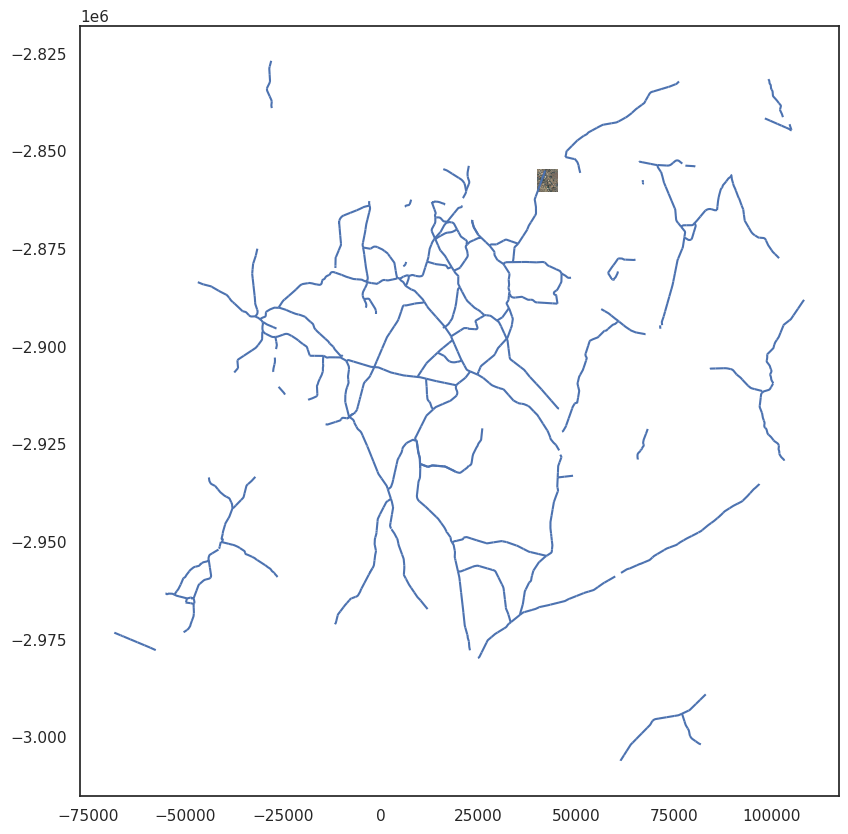

In [154]:
raster_crs = src_mask.crs

fig, ax = plt.subplots(figsize=(10,10))

# transform rasterio plot to real world coords
extent = [src_mask.bounds[0], src_mask.bounds[2], src_mask.bounds[1], src_mask.bounds[3]]
ax = plot.show(src, extent=extent, ax=ax, cmap="pink")

gdf.plot(ax=ax);